In [ ]:
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("movies_dataset.csv")
print("Initial dataset shape:", df.shape)
df.head()

Initial dataset shape: (1072, 7)


,title,year,budget_raw,box_office_raw,release_date,section,image
0,Traffic in Souls,1913,"$5,700 [ 1 ]","$981,000 (US)[citation needed]",NaN,Highest-grossing,images\1913_Traffic_in_Souls.jpg
1,The Spoilers,1914,NaN,"$1,000,000[14]",NaN,Highest-grossing,images\1914_The_Spoilers.jpg
2,Dough and Dynamite,1914,NaN,"$130,000[15]",NaN,Highest-grossing,images\1914_Dough_and_Dynamite.jpg
3,The Virginian,1914,NaN,"$111,518[15]",NaN,Highest-grossing,images\1914_The_Virginian.jpg
4,Rose of the Rancho,1914,NaN,"$87,028[15]",NaN,Highest-grossing,images\1914_Rose_of_the_Rancho.jpg


The data is completely of Highest grossing movies per year

In [103]:
count_highest = (df["section"] == "Highest-grossing").sum()
total_rows = len(df)

print(f"Highest-grossing movies: {count_highest}")
print(f"Total movies: {total_rows}")
print(f"Percentage: {count_highest/total_rows:.2%}")

Highest-grossing movies: 1072
Total movies: 1072
Percentage: 100.00%


# Text cleaning
Here we are removing citations [1], [2] and parenthetical notes and converting fancy dashes/quotes/apostrophes to plain ASCII equivalents

In [ ]:
def remove_brackets(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r"\[.*?\]", "", text)    
    text = re.sub(r"\(.*?\)", "", text) 
    return text.strip()

df["budget_raw"] = df["budget_raw"].apply(remove_brackets)
df["box_office_raw"] = df["box_office_raw"].apply(remove_brackets)

def normalize_text(text):
    if not isinstance(text, str):
        return text
    text = unicodedata.normalize("NFKC", text)
    text = text.replace("–", "-").replace("—", "-")
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("’", "'")
    return text.strip()

df["title"] = df["title"].apply(normalize_text)
df["budget_raw"] = df["budget_raw"].apply(normalize_text)
df["box_office_raw"] = df["box_office_raw"].apply(normalize_text)

# Money cleaning: 
extracting numeric values from budget/box office strings and convert to millions USD. and converting units like billion/million/thousand, ranges (averages), and plain raw dollar values 


In [ ]:
def clean_money(value):
    if not isinstance(value, str):
        return None
    value = value.replace(",", "").replace("US$", "$").strip()

    matches = re.findall(r"\$([\d\.]+)", value)
    if not matches:
        return None

    nums = []
    for m in matches:
        num = float(m)

        if "billion" in value.lower():
            nums.append(num * 1000)   
        elif "million" in value.lower():
            nums.append(num)         
        elif "thousand" in value.lower():
            nums.append(num * 0.001) 
        else:
            nums.append(num / 1e6)   

    return sum(nums) / len(nums) if nums else None


def clean_money_with_range(value):
    return clean_money(value) 

df["budget_millionUSD"] = df["budget_raw"].apply(clean_money_with_range)
df["box_office_millionUSD"] = df["box_office_raw"].apply(clean_money_with_range)

df[["title", "year", "budget_raw", "budget_millionUSD", "box_office_raw", "box_office_millionUSD"]].head(100)
# df[["title", "year", "budget_raw", "budget_millionUSD", "box_office_raw", "box_office_millionUSD"]].tail(100)

,title,year,budget_raw,budget_millionUSD,box_office_raw,box_office_millionUSD
972,Star Wars: The Force Awakens,2015,$447 million $533 million,490.0,"$2,068,223,624",2068.223624
973,Jurassic World,2015,$150-215 million,150.0,"$1,670,400,637",1670.400637
974,Furious 7,2015,$190-250 million,190.0,"$1,515,047,671",1515.047671
975,Avengers: Age of Ultron,2015,$444-495.2 million $365 million,404.5,"$1,402,809,540",1402.809540
976,Minions,2015,$74 million,74.0,"$1,159,398,397",1159.398397
...,...,...,...,...,...,...
1067,Mufasa: The Lion King,2024,$200 million,200.0,"$723,060,982",723.060982
1068,Dune: Part Two,2024,$190 million,190.0,"$715,409,065",715.409065
1069,Godzilla x Kong: The New Empire,2024,$135-150 million,135.0,"$572,505,338",572.505338
1070,Kung Fu Panda 4,2024,$85 million,85.0,"$547,689,492",547.689492


here we are finding the missing values in our data

In [79]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
title                       0
year                        0
budget_raw                138
box_office_raw              0
release_date             1072
section                     0
image                       5
budget_millionUSD         155
box_office_millionUSD       0
dtype: int64


# We are looking for the rows in data where budget_raw is missing

In [ ]:
missing_budget_rows = df[df["budget_raw"].isna()]
print("Rows with missing budget_raw:")
display(missing_budget_rows[["title", "year", "budget_raw", "box_office_raw"]])

Rows with missing budget_raw:


,title,year,budget_raw,box_office_raw
1,The Spoilers,1914,NaN,"$1,000,000"
2,Dough and Dynamite,1914,NaN,"$130,000"
3,The Virginian,1914,NaN,"$111,518"
4,Rose of the Rancho,1914,NaN,"$87,028"
5,The Man from Home,1914,NaN,"$62,091"
...,...,...,...,...
1024,"My People, My Homeland",2020,NaN,"$433,241,288"
1029,Jiang Ziya,2020,NaN,"$243,883,429"
1030,A Little Red Flower,2020,NaN,"$238,600,000"
1050,The Battle at Lake Changjin II,2022,NaN,"$626,571,697"


# similarly here we are looking for data that is not parsed into a number

In [ ]:
unparsable_budget = df[(df["budget_raw"].notna()) & (df["budget_millionUSD"].isna())]
print("Rows with unparsable budgets:")
display(unparsable_budget[["title", "year", "budget_raw", "box_office_raw"]])

Rows with unparsable budgets:


,title,year,budget_raw,box_office_raw
12,Temptation,1915,"$ 22,472.25","$102,437"
16,Chimmie Fadden,1915,"$ 10,504.39","$78,944"
26,The Little American,1917,"$ 166,949.16","$446,236"
35,Male and Female,1919,"$ 168,619.28","$1,256,267"
39,Don't Change Your Husband,1919,"$ 73,922.14","$292,394"
40,"For Better, for Worse",1919,"$ 1,260.93","$256,072"
59,Saturday Night,1922,"$ 224,635","$753,807"
77,Feet of Clay,1924,"$ 513,636.27","$904,383"
312,The Red Shoes,1948,"> £ 505,600","$5,000,000"
465,Tom Jones,1963,"£467,000 or £480,000","$17,070,000"


# Here is get to know that there are also some rows where budget is mentioned in some different currencies apart from dollar and previously we only handles dollar case that's why these rows are not parsable 
# I can convert these budgets also but since majority of our data is in dollars so i will drop these rows from the data
# I could have also taken the mean or meadian as budget but the data is highly skewed toward large budgets so it is better to drop them 

In [82]:
df_model = df.dropna(subset=["budget_millionUSD"]).copy()

# now we have 917 rows left in data

In [83]:
df_model.shape

(917, 9)

In [84]:
print("Missing values per column:")
print(df_model.isna().sum())

Missing values per column:
title                      0
year                       0
budget_raw                 0
box_office_raw             0
release_date             917
section                    0
image                      2
budget_millionUSD          0
box_office_millionUSD      0
dtype: int64


In [85]:
df_model[["budget_millionUSD", "box_office_millionUSD"]].describe()


,budget_millionUSD,box_office_millionUSD
count,917.000000,917.000000
mean,2572.220158,267.210086
std,39900.338907,394.108248
min,0.005700,0.068526
25%,2.000000,4.633486
50%,9.000000,50.000000
75%,80.000000,432.243292
max,849127.875000,2799.439100


# above we can see that the maximum value is very large it may be a parsing error so to remove this outlier i restrict the budget of the movies to be less than equal to 500

In [86]:
df_model = df_model[df_model["budget_millionUSD"] <= 500]


In [87]:
df_model[["budget_millionUSD", "box_office_millionUSD"]].describe()

,budget_millionUSD,box_office_millionUSD
count,913.000000,913.000000
mean,49.941413,268.357449
std,75.554697,394.588890
min,0.005700,0.068526
25%,2.000000,4.700000
50%,8.750000,50.427646
75%,80.000000,433.371112
max,490.000000,2799.439100


# so we have 913 rows left now

In [88]:
df_model.shape

(913, 9)

# here iam plotting various plots of movie Budgets and movie box office and we can see that the data is highly skewed so before training our ML model on this data we can log of the values to make them in similar ranges so that our regression model can predict much better 
# we are not using standard scalling because we are not using distance based models

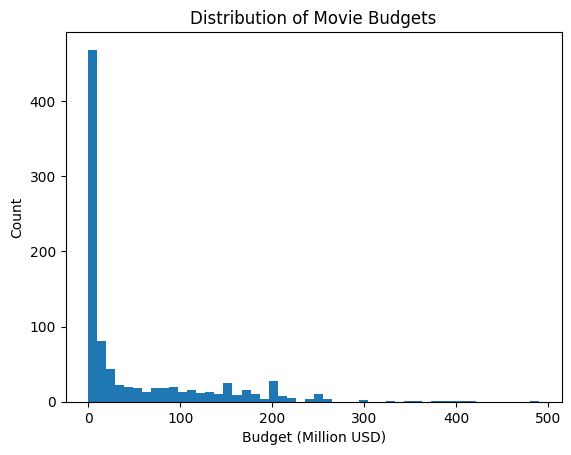

In [70]:
plt.hist(df_model["budget_millionUSD"], bins=50)
plt.xlabel("Budget (Million USD)")
plt.ylabel("Count")
plt.title("Distribution of Movie Budgets")
plt.show()

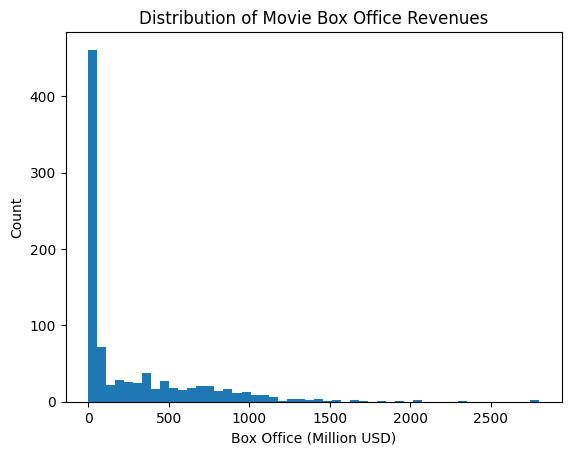

In [71]:
plt.hist(df_model["box_office_millionUSD"], bins=50)
plt.xlabel("Box Office (Million USD)")
plt.ylabel("Count")
plt.title("Distribution of Movie Box Office Revenues")
plt.show()

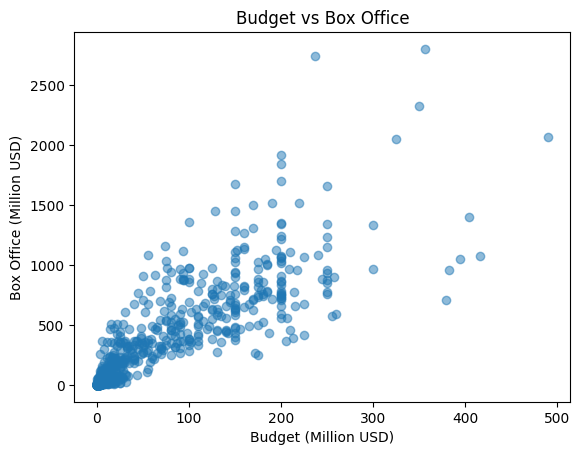

In [72]:
plt.scatter(df_model["budget_millionUSD"], df_model["box_office_millionUSD"], alpha=0.5)
plt.xlabel("Budget (Million USD)")
plt.ylabel("Box Office (Million USD)")
plt.title("Budget vs Box Office")
plt.show()

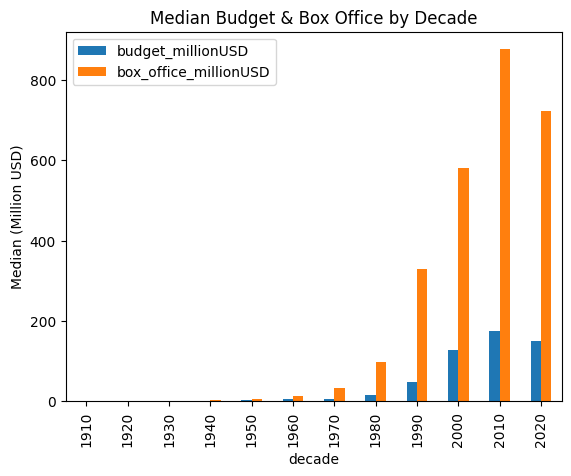

In [73]:
df_model["decade"] = (df_model["year"] // 10) * 10
df_model.groupby("decade")[["budget_millionUSD", "box_office_millionUSD"]].median().plot(kind="bar")
plt.ylabel("Median (Million USD)")
plt.title("Median Budget & Box Office by Decade")
plt.show()

# Here i am doing title cleaning and Log transform for later regression 

In [ ]:
df_model["title_clean"] = df_model["title"].str.replace(r"\[.*?\]", "", regex=True).str.strip()

df_model["log_budget"] = np.log1p(df_model["budget_millionUSD"])
df_model["log_box_office"] = np.log1p(df_model["box_office_millionUSD"])

Box plot also demonstrates that our data is highly skewed and there are more big budget outliers

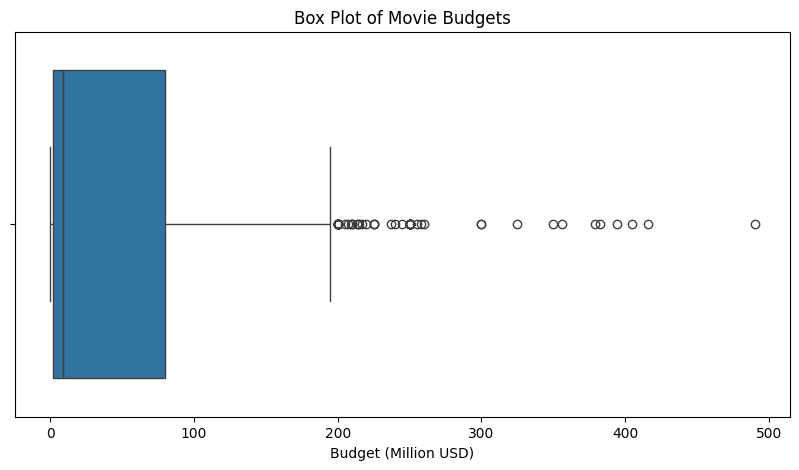

In [90]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_model["budget_millionUSD"])
plt.title("Box Plot of Movie Budgets")
plt.xlabel("Budget (Million USD)")
plt.show()

In [98]:
# df_model = df_model.drop(columns=["release_date"])
df_model = df_model.drop(columns=["section"])


# Here we are plotting correlation matrix of numeric coloumns

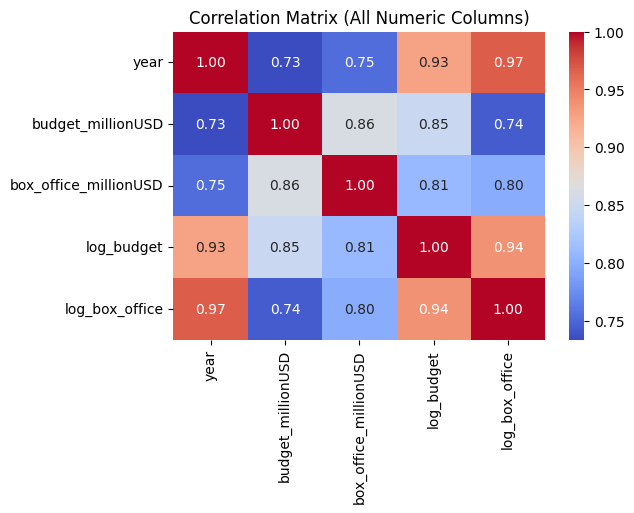

In [ ]:
corr = df_model.corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (All Numeric Columns)")
plt.show()


In [99]:
df_model.head()

,title,year,budget_raw,box_office_raw,image,budget_millionUSD,box_office_millionUSD,title_clean,log_budget,log_box_office
0,Traffic in Souls,1913,"$5,700","$981,000",images\1913_Traffic_in_Souls.jpg,0.005700,0.981000,Traffic in Souls,0.005684,0.683602
9,The Birth of a Nation,1915,"$100,000+","$10,000,000",images\1915_The_Birth_of_a_Nation.jpg,0.100000,10.000000,The Birth of a Nation,0.095310,2.397895
10,Carmen,1915,"$23,429","$147,600",images\1915_Carmen.jpg,0.023429,0.147600,Carmen,0.023159,0.137673
11,The Cheat,1915,"$17,311","$137,364",images\1915_The_Cheat.jpg,0.017311,0.137364,The Cheat,0.017163,0.128713
15,The Golden Chance,1915,"$18,711","$83,504",images\1915_The_Golden_Chance.jpg,0.018711,0.083504,The Golden Chance,0.018538,0.080200


# Saving the cleaned dataset for modelling

In [ ]:
df_model.to_csv("clean_movies_dataset.csv", index=False)